In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import bte
import datetime as dt

Let's say we are naively interested in nucleotide diversity over time. BTE provides a nucleotide diversity function, but first we need to extract subtrees representing our time periods of interest.

In [2]:
mat = bte.MATree("public-2022-04-08.all.masked.nextclade.pangolin.pb.gz")

Finished 'from_pb' in 33.0495 seconds


In [3]:
samples = mat.get_leaves_ids()
samplecount = len(samples)
samplecount

Finished 'get_leaves_ids' in 2.969 seconds


4727267

Standard sample naming practices for SARS-CoV-2 public data uploads include the date of submission at the end after a "|" delimiter- we can extract and parse these dates to subdivide the tree. Alternatively, UCSC provides a metadata file accompanying global public tree protocol buffers which includes dates, but for the purposes of demonstration we will use only information included in the tree itself.

In [4]:
datedf = {k:[] for k in ['Sample','Date']}
for s in samples:
    #some dates are misformatted or missing
    try:
        date = dt.datetime.strptime(s[s.rfind("|")+1:],'%Y-%m-%d')
        datedf['Sample'].append(s)
        datedf['Date'].append(date)
    except:
        continue
datedf = pd.DataFrame(datedf)
datedf.shape[0]

4712678

In [5]:
#some samples have mislabeled dates, so we restrict our selection to dates ranging from December 2019 to April 2022.
datedf = datedf[(datedf.Date > dt.datetime(year=2019,month=12,day=1)) & (datedf.Date < dt.datetime(year=2022,month=4,day=8))]
#99.7% of the tree is correctly annotated with date information. This is more than enough to proceed
datedf.shape[0]/len(samples)

0.9969130154907687

Text(0.5, 0, 'Month')

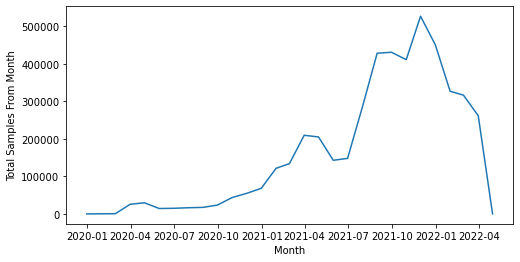

In [6]:
x,y = [],[]
for t,sdf in datedf.groupby(pd.Grouper(key='Date',freq='1M')):
    x.append(t)
    y.append(len(sdf))
plt.figure(figsize=[8,4])
ax = sns.lineplot(x=x,y=y)
ax.set_ylabel("Total Samples From Month")
ax.set_xlabel("Month")

Total samples collected is a complex function of total caseload and rates of sequencing integrated across separate countries. Generally, most of our data was obtained from 2021 and after, as sequencing efforts intensified globally and total infections increased with the increasing transmissibility of Delta and Omicron. The seeming decline in April 2022 is because this notebook is based on all data collected as of the first week of April, making it underrepresented in our final data. March, as well, is somewhat underrepresented as data collected in the latter two weeks of March may not have yet been fully uploaded and incorporated into the phylogeny.

The phylogeny also includes clade information. How do clade samples vary across time? Let's repeat the above analysis with clade information.

In [7]:
datedf = {k:[] for k in ['Sample','Date','Clade']}
for s in mat.get_leaves():
    try:
        date = dt.datetime.strptime(s.id[s.id.rfind("|")+1:],'%Y-%m-%d')
    except:
        continue
    datedf['Sample'].append(s)
    datedf['Date'].append(date)
    #since the annotations are not statically assigned to every leaf for memory efficiency
    #it needs to locate the annotations associated with a leaf on the tree
    #therefore this step takes a few seconds additional computational time
    datedf['Clade'].append(s.annotations[0])

datedf = pd.DataFrame(datedf)
datedf.shape[0]

Finished 'get_leaves' in 1.0193 seconds


4712678

In [8]:
datedf

,Sample,Date,Clade
0,<bte.MATNode object at 0x7f8309a96830>,2020-03-06,19A
1,<bte.MATNode object at 0x7f8309a965f0>,2020-02-17,19A
2,<bte.MATNode object at 0x7f82ebf6b370>,2020-02-17,19A
3,<bte.MATNode object at 0x7f82ebf6b170>,2020-03-17,19A
4,<bte.MATNode object at 0x7f82ebf6b0d0>,2020-03-16,19A
...,...,...,...
4712673,<bte.MATNode object at 0x7f82ba2c38f0>,2021-12-01,None
4712674,<bte.MATNode object at 0x7f82ba2c3910>,2021-10-19,None
4712675,<bte.MATNode object at 0x7f82ba2c3930>,2021-10-21,None
4712676,<bte.MATNode object at 0x7f82ba2c3950>,2021-12-21,None


In [9]:
datedf = datedf[(datedf.Date > dt.datetime(year=2019,month=12,day=1)) & (datedf.Date < dt.datetime(year=2022,month=4,day=8))]
datedf.shape[0]/len(samples)

0.9969130154907687

Text(0.5, 0, 'Month')

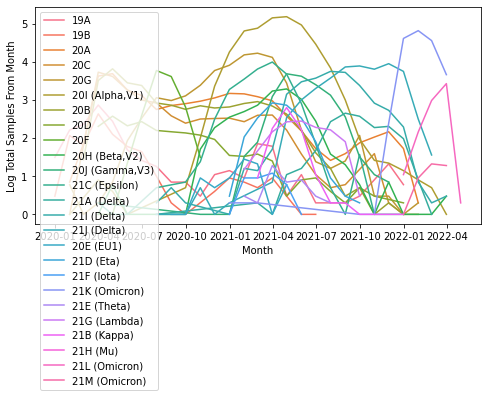

In [10]:
x,y,h = [],[],[]
for t,sdf in datedf.groupby(pd.Grouper(key='Date',freq='1M')):
    for ann,ssdf in sdf.groupby('Clade'):
        x.append(t)
        y.append(np.log10(ssdf.shape[0]))
        h.append(ann)
plt.figure(figsize=[8,4])
ax = sns.lineplot(x=x,y=y,hue=h,legend=True)
ax.set_ylabel("Log Total Samples From Month")
ax.set_xlabel("Month")

With every clade, this plot is a bit of a tangle. However, its clear that some general variants are more likely to succeed than others- Delta outcompeted Alpha, and Omicron outcompeted Delta. Let's take a closer look at these groups.

In [11]:
cdf = {k:[] for k in ['Month','LogCount','VOC']}
for month,lc,h in zip(x,y,h):
    if 'Alpha' in h:
        cdf['Month'].append(month)
        cdf['LogCount'].append(lc)
        cdf['VOC'].append('Alpha')
    elif 'Delta' in h:
        cdf['Month'].append(month)
        cdf['LogCount'].append(lc)
        cdf['VOC'].append('Delta')
    elif 'Omicron' in h:
        cdf['Month'].append(month)
        cdf['LogCount'].append(lc)
        cdf['VOC'].append('Omicron')
cdf = pd.DataFrame(cdf)
cdf = cdf.groupby(['Month','VOC']).sum().reset_index()

<AxesSubplot:xlabel='Month'>

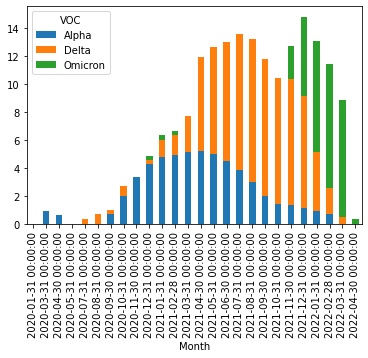

In [12]:
cdf.pivot_table(index='Month',columns='VOC').plot.bar(y='LogCount',stacked=True)

This lets us examine the global pattern of succession of these variants. 

There appear to be some mislabeled Omicron and Delta samples with dates putting them in late 2020- possibly due to errors in fixing a default year when uploading sequence data. 

We can see that Alpha was dominant until early 2021, at which point Delta fairly gradually began to be a large part of samples collected. By late 2021, Delta was most of what was being sampled.

Omicron, by contrast, had an explosive emergence, appearing as a significant portion of samples collected within a month of being detected at all in early 2022. It quickly became the bulk of sequences collected in recent months.